In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")

### Problem 1

In [208]:
df=pd.read_csv("data/incomes.txt",names=['Income'])
df.head()

,Income
0,51253.497156
1,100630.320241
2,83009.276137
3,82882.106543
4,77338.294839


In [209]:
df.describe()

,Income
count,200.000000
mean,87588.930769
std,18081.166388
min,49278.801938
25%,74088.607447
50%,85801.697366
75%,100102.725206
max,135865.026796


##### a

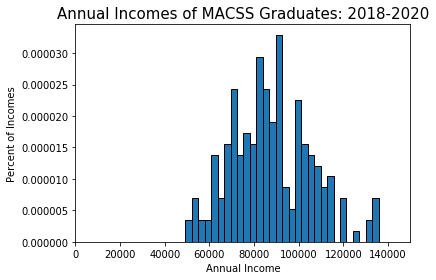

In [210]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])
plt.show()

##### b

In [211]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

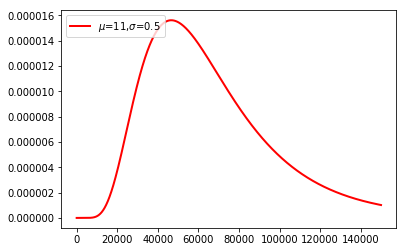

In [212]:
# Plot smooth line with distribution (mu_1 = 11, sig_1 = 0.5)
dist_pts = np.linspace(1, 150000, 3000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1,sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.show()

In [213]:
# Define log likelihood function for the log normal distribution
def log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood:', log_lik_trunclognorm(df['Income'], mu_1, sig_1, 0, 150000))

Log-likelihood: -2379.120591931827


##### c

In [214]:
def crit(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunclognorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [215]:
mu_init = 10
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (df['Income'], 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE= results_uncstr.x[0]
sig_MLE = -results_uncstr.x[1]
print('ML estimates for µ=', mu_MLE)
print('ML estimates for σ', sig_MLE)
print("Maximized Log Likelihood:",log_lik_trunclognorm(df['Income'], mu_MLE, sig_MLE, 0, 150000))

ML estimates for µ= 11.361699975021795
ML estimates for σ 0.2117432788726898
Maximized Log Likelihood: -2240.934337511636


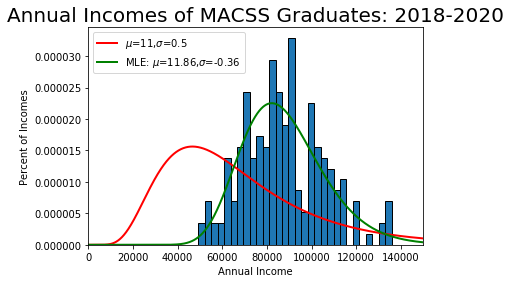

In [216]:
# Plot the histogram of the data
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')

# Plot the PDF from (b)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE,sig_MLE, 0, 150000),
         linewidth=2, color='g', label='MLE: $\mu$=11.86,$\sigma$=-0.36')
plt.legend(loc='upper left')

plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([0, 150000]) 
plt.show()

In [217]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('mu percent', 100*stderr_mu_mle/mu_MLE,"%")
print('sig percent', 100*stderr_sig_mle/sig_MLE,"%")

VCV(MLE) =  [[ 2.14293375e-04 -1.20173290e-05]
 [-1.20173290e-05  1.30638926e-04]]
Standard error for mu estimate =  0.014638762766080225
Standard error for sigma estimate =  0.011429738647692086
mu percent 0.1288430674834128 %
sig percent 5.397922762197421 %


##### d

In [218]:
mu_new, sig_new = np.array([420, 130])
log_lik_h0 = log_lik_trunclognorm(df['Income'], mu_1, sig_1, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_trunclognorm(df['Income'], mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.934337511636
likelihood ratio value 276.3725088403826
chi squared of H0 with 2 degrees of freedom p-value =  0.0


p-value is very small, so we can reject the null hypothesis that the probability that the data comes from is f(x|mu=11,sigma=0.5).

##### e

In [219]:
1-sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))

0.2375540357115089

There is 24% of the chance that I will earn more than $100000.

In [220]:
sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))

0.25964393792847373

There is 26% of the chance that I will earn less than $75000.

### Problem 2

##### a

In [228]:
df=pd.read_csv("data/sick.txt").astype('float64')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [237]:
df.describe()

,sick,age,children,avgtemp_winter
count,200.000000,200.000000,200.000000,200.000000
mean,1.008600,40.683850,1.674950,44.041250
std,0.504222,11.268686,0.969761,11.101977
min,0.040000,12.810000,0.000000,16.500000
25%,0.650000,33.967500,0.970000,36.112500
50%,0.960000,41.015000,1.560000,43.300000
75%,1.322500,47.750000,2.322500,52.172500
max,2.800000,74.890000,4.960000,68.600000


In [230]:
def norm_pdf(xvals, sig):
    sig=abs(sig)
    pdf_vals = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(xvals)**2 / (2*sig**2))                  
    return pdf_vals

In [223]:
def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig):
    
    err=y-b0-b1*x1-b2*x2-b3*x3
    pdf_vals = norm_pdf(err, sig)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [224]:
def crit2(params,*args):
    
    b0, b1, b2, b3, sig = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig)
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val

In [225]:
b0_init, b1_init, b2_init, b3_init, sig_init = (0.2,0,0,0,1)
y=df['sick']
x1, x2, x3 = df['age'], df['children'], df['avgtemp_winter']
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sig_init])
results = opt.minimize(crit2, params_init,(y, x1, x2, x3))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results.x
print('beta 0=', b0_MLE)
print('beta 1=', b1_MLE)
print('beta 2=', b2_MLE)
print('beta 3=', b3_MLE)
print('sigma=', sig_MLE)
print("Value of the log likelihood function:",-results.fun)

beta 0= 0.2516462863009143
beta 1= 0.012933350241651839
beta 2= 0.4005020598812094
beta 3= -0.009991671522641493
sigma= 0.0030177004489735067
Value of the log likelihood function: 876.8650468414168


In [226]:
vcv_mle = results.hess_inv
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[ 1.08579401e-06  4.52195731e-09 -1.47000525e-07 -2.20502350e-08
   5.57249528e-09]
 [ 4.52195731e-09  4.20615273e-09 -3.71445246e-08 -2.57941093e-09
  -1.28317610e-10]
 [-1.47000525e-07 -3.71445246e-08  3.77442634e-07  2.33178375e-08
   6.82198342e-10]
 [-2.20502350e-08 -2.57941093e-09  2.33178375e-08  1.99610060e-09
  -2.42837085e-11]
 [ 5.57249528e-09 -1.28317610e-10  6.82198342e-10 -2.42837085e-11
   2.31215973e-08]]


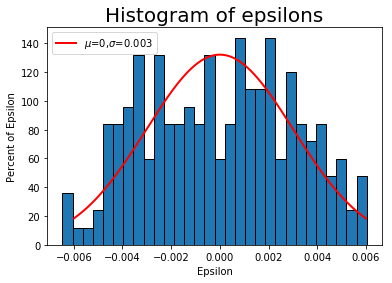

In [245]:
# Plot the histogram of the data
plt.hist(y-b0_MLE-b1_MLE*x1-b2_MLE*x2-b3_MLE*x3, num_bins, normed=True, edgecolor='k')

dist_pts=np.linspace(-0.006,0.006,1000)
plt.plot(dist_pts, norm_pdf(dist_pts, sig_MLE),
         linewidth=2, color='r', label='$\mu$=0,$\sigma$=0.003')
plt.legend(loc='upper left', fontsize=10)

plt.title('Histogram of epsilons', fontsize=20)
plt.xlabel('Epsilon')
plt.ylabel('Percent of Epsilon')
plt.show()

##### b

In [249]:
b0_t, b1_t, b2_t, b3_t, sig_t = 1, 0, 0, 0, 0.1
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0_t, b1_t, b2_t, b3_t, sig_t)
print('hypothesis value log likelihood', log_lik_h0)
print('MLE log likelihood', -results.fun)
LR_val = 2 * ((-results.fun)-log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('Chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650468414168
likelihood ratio value 6261.131469767083
Chi squared of H0 with 5 degrees of freedom p-value =  0.0


We could reject the null hypothesis that age, number of children, and average winter temperature have no effect on the number of sick days. So there is 0% that age, number of children, and average winter temperature have no effect on the number of sick days.